In [52]:
import netCDF4 as nc4
import matplotlib.pyplot as plt
import numpy as np

import datetime as dt
from matplotlib import cm, ticker, rcParams
from tqdm import tqdm
import scipy.optimize as opt
import scipy.ndimage as nd
import scipy.interpolate as interp
from matplotlib.gridspec import GridSpec
import matplotlib.colors as col #ListedColormap
import matplotlib.path as mpp

rcParams['pcolor.shading']='auto'
path_in='../../Analysis/QWA_Article_npy/'
t_bd_bis=[115,170]  ### timesteps range for first summer
t_bd_ter=[295,350]  ### timesteps range for second summer
t_win=[225,295]     ### timesteps range for second winter (first winter is in the transient)

## Checking mean Heat flux / wind stress difference (diff experiments)

In [53]:
DE=np.load(path_in+'DictEddy_HIS_QWA204.npy',allow_pickle=True) ; DE=DE.item()
W1hour=DE['Wspeed'] ; Q1hour=DE['Qmean']
DE=np.load(path_in+'DictEddy_HIS_QWA120.npy',allow_pickle=True) ; DE=DE.item()
Wnobulk=DE['Wspeed'] ; Qnobulk=DE['Qmean']
DE=np.load(path_in+'DictEddy_HIS_QWA117.npy',allow_pickle=True) ; DE=DE.item()
W1day=DE['Wspeed'] ; Q1day=DE['Qmean']
DE=np.load(path_in+'DictEddy_HIS_QWA122.npy',allow_pickle=True) ; DE=DE.item()
W3days=DE['Wspeed'] ; Q3days=DE['Qmean']
DE=np.load(path_in+'DictEddy_HIS_QWA118.npy',allow_pickle=True) ; DE=DE.item()
W1week=DE['Wspeed'] ; Q1week=DE['Qmean']

In [54]:
time=DE['time_a']

def fill_seasons(t_sum1,t_sum2,t_win,bounds):
    plt.fill_betweenx(bounds,[time[t_sum1[0]]]*2,[time[t_sum1[1]]]*2,color='peachpuff')
    plt.fill_betweenx(bounds,[time[t_sum2[0]]]*2,[time[t_sum2[1]]]*2,color='peachpuff')
    plt.fill_betweenx(bounds,[time[t_win[0]]]*2,[time[t_win[1]]]*2,color='lightblue')

Text(0, 0.5, 'Mean heat flux [W/m2]')

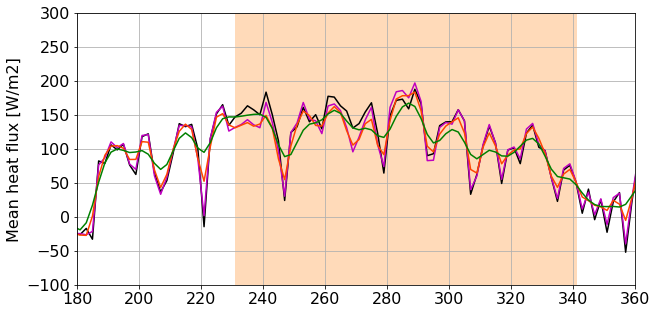

In [55]:
plt.figure(figsize=(10,5)) ; LS=16
plt.plot(time, Q1hour,'-k') 
plt.plot(time, Q1day,'-m') 
plt.plot(time, Q3days,'-', color='orangered') 
plt.plot(time, Q1week,'-g') 

plt.xlim([180,360]) ; plt.grid() , plt.ylim([-100,300])
fill_seasons(t_bd_bis,t_bd_ter,t_win,[-400,300])
plt.tick_params(labelsize=LS)     #### Wind  

plt.ylabel('Mean heat flux [W/m2]',size=16)

In [56]:
### Checking Heat flux mean difference in summer
np.mean((Q1hour-Qnobulk)[90:180]), np.mean((Q1day-Q1hour)[90:180]) , np.mean((Q1week-Q1hour)[90:180])

(-9.426431613498265, -1.3072345309787325, -0.9538927714029948)

Text(0, 0.5, 'Equivalent wind speed [m/s]')

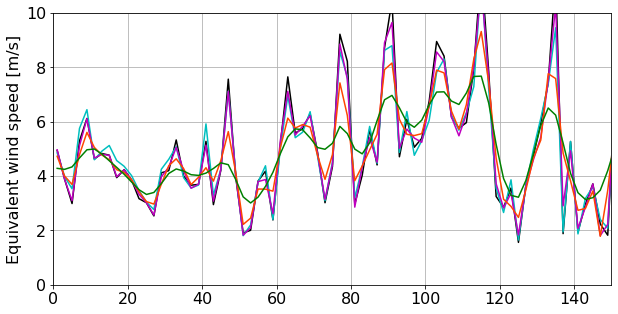

In [57]:
plt.figure(figsize=(10,5))
plt.plot(time, W1hour,'-k')
plt.plot(time, Wnobulk,'-c') 
plt.plot(time, W1day,'-m') 
plt.plot(time, W3days,'-', color='orangered') 
plt.plot(time, W1week,'-g') 

plt.xlim([0,150]) ; plt.ylim([0,10]) ;plt.grid()
fill_seasons(t_bd_bis,t_bd_ter,t_win,[-400,300])
plt.tick_params(labelsize=LS)     #### Wind  

plt.ylabel('Equivalent wind speed [m/s]',size=16)

In [58]:
### Checking Wind stress mean difference in summer
np.mean(W1day-W1hour)/np.mean(W1hour) , np.mean(W3days-W1hour)/np.mean(W1hour) , np.mean(W1week-W1hour)/np.mean(W1hour)


(-0.008388651331661782, -0.004887861583741294, -0.003503063427013736)

## One time serie as example

In [59]:
DE=np.load(path_in+'DictEddy_HIS_QWA204.npy',allow_pickle=True) ; DE=DE.item()
DE.keys()

dict_keys(['timeeddy', 'Rmax', 'Vmax', 'time_a', 'time_h', 'Qin', 'Qmean', 'Wspeed', 'SSTin_h', 'SSTperif_h', 'SSTout_h', 'MLDout_h', 'MLDcore_h', 'MLDrmax_h', 'WOut_h', 'WEddy_h', 'TempEddy_h', 'TempCoreRmin_h', 'TempOut_h', 'zvert', 'MixEddy_h', 'MixOut_h', 'z_dzt'])

In [60]:
timeed=DE['timeeddy']  ### 1D Var
Rmaxed=DE['Rmax']
Vmaxed=DE['Vmax']
time=DE['time_a']
time_h=DE['time_h']
Qin=DE['Qin']
Qmean=DE['Qmean']
Wspeed=DE['Wspeed']
SSTin_h=DE['SSTin_h']
SSTperif_h=DE['SSTperif_h']
SSTout_h=DE['SSTout_h']
MLDout_h=DE['MLDout_h']
MLDrmax_h=DE['MLDrmax_h']#=MLDrmax_h
DeltaT_h=SSTin_h-SSTperif_h
DeltaQ=Qin-Qmean
DeltaMLD_sm=nd.gaussian_filter1d(MLDrmax_h-MLDout_h,sigma=2)

#WOut_h=DE['WOut_h'] ; WEddy_h=DE['WEddy_h'] ### 2D var
zvert=DE['zvert']
TempEddy_h=DE['TempEddy_h']
MixEddy_h=DE['MixEddy_h']
MixOut_h=DE['MixOut_h']
#DE['z_dzt']=z_dzt

# Hovmueller BVF

In [61]:
Mask=np.isnan(DeltaT_h)
Nvert=len(zvert) ; Ns=len(time)
T0=25 ; R0=26 ; Tcoef=0.28
N_eddy_h=np.zeros((Ns,Nvert-1))
zs=(zvert[1:]+zvert[:-1])/2
for t in range(Ns):
    N_eddy_h[t]= np.sqrt(-9.81 * np.diff(R0-Tcoef*(TempEddy_h[t]-T0))/np.diff(zvert)/1026)
N_eddy_h[N_eddy_h<0.001]=np.nan
Levels=list(np.arange(0.1,1,0.1))+list(np.arange(1,2,0.5))
months=['O','N','D','J','F','M','A','M','J','J','A','S']

<ipython-input-61-80a8bbfca507>:7: RuntimeWarning: invalid value encountered in sqrt
  N_eddy_h[t]= np.sqrt(-9.81 * np.diff(R0-Tcoef*(TempEddy_h[t]-T0))/np.diff(zvert)/1026)


<ipython-input-62-913bdec322b2>:55: RuntimeWarning: invalid value encountered in true_divide
  MR20=nd.gaussian_filter1d(np.average(MixEddy_h[:,id20:]/MixOut_h[:,id20:],axis=1),sigma=1)
<ipython-input-62-913bdec322b2>:57: RuntimeWarning: invalid value encountered in true_divide
  MR50=nd.gaussian_filter1d(np.average(MixEddy_h[:,id50:]/MixOut_h[:,id50:],axis=1),sigma=1)


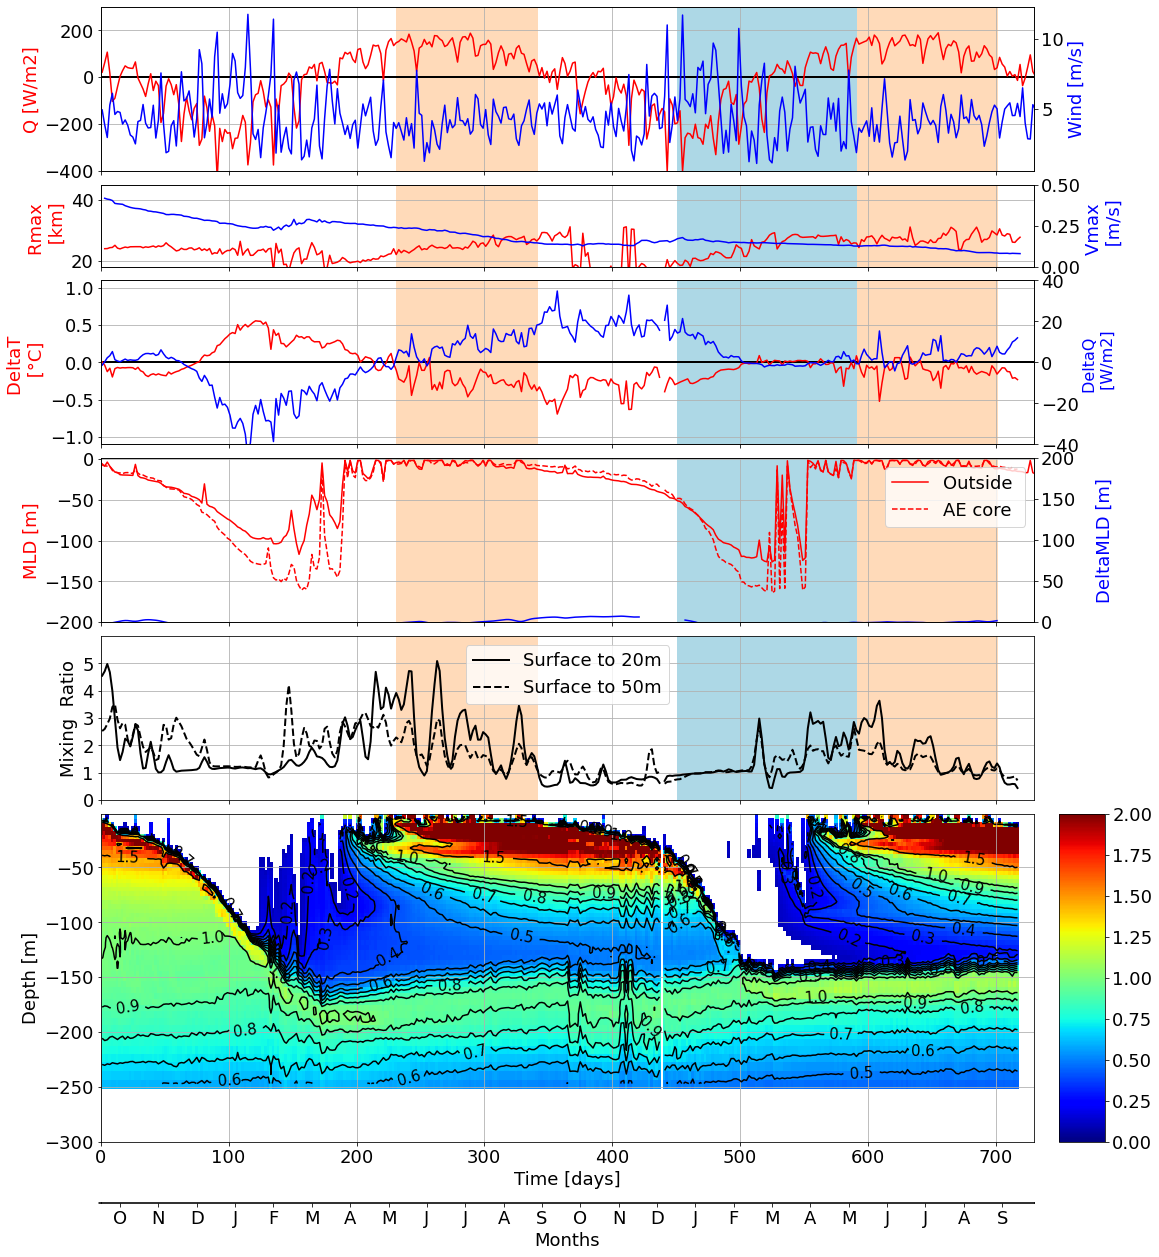

In [62]:
plt.figure(0, figsize=(18,22)) ; LS=18 ; dTmax=1.1
id20 =np.argmin(np.abs(zvert+20)) ; id50 =np.argmin(np.abs(zvert+50))

gs = GridSpec(8, 2, width_ratios=[20,1], height_ratios=[2,1,2,2,2,4,0.4,0.01], wspace=0.05, hspace=0.1)

ax2 = plt.subplot(gs[0,0])                                     ### Q 
plt.plot([0,time[-1]],[0,0],'-k',lw=2)
plt.plot(time, Qmean,'-r') ; plt.grid() ; plt.tick_params(labelbottom=False, labelsize=LS)
plt.ylabel('Q [W/m2]',size=LS, color='r')
plt.xlim([0,2*365]) ; plt.ylim([-400,300])
fill_seasons(t_bd_bis,t_bd_ter,t_win,[-400,300])
ax3=ax2.twinx() ; plt.tick_params(labelsize=LS)     #### Wind  
plt.plot(time, Wspeed,'-b') 
plt.ylabel('Wind [m/s]',size=LS, color='b')

ax0= plt.subplot(gs[1,0])                                  ###### RMAX
plt.plot(timeed,Rmaxed,'-r')
fill_seasons(t_bd_bis,t_bd_ter,t_win,[-400,300])
plt.grid() ; plt.ylabel('Rmax \n [km]', size=LS, color='r') ; plt.tick_params(labelbottom=False, labelsize=LS)
plt.xlim([0,2*365]) ; plt.ylim([18,45])
          
ax1=ax0.twinx(); plt.tick_params(labelbottom=False, labelsize=LS)  ###### VMAX
ax1.plot(timeed, Vmaxed,'-b')
plt.ylim([0.0,0.5])
plt.ylabel('Vmax \n [m/s]', size=LS, color='b')

ax4 = plt.subplot(gs[2,0])                                      ### DeltaSST
plt.plot([0,time_h[-1]],[0,0],'-k',lw=2)
plt.plot(time, DeltaT_h,'-r') ; plt.grid() ; plt.tick_params(labelbottom=False, labelsize=LS)
fill_seasons(t_bd_bis,t_bd_ter,t_win,[-400,300])
plt.ylabel('DeltaT \n [\N{DEGREE SIGN}C]',size=LS,color='r')
plt.yticks(np.arange(-2,3,0.5))
plt.xlim([0,2*365]) ;plt.ylim([-dTmax,dTmax])

ax5=ax4.twinx() ; plt.tick_params(labelsize=LS)    ##### Delta Q
plt.plot(time, DeltaQ,'-b') 
plt.ylim([-40,40])
plt.ylabel('DeltaQ \n [W/m2]', size=16, color='b')

ax4=plt.subplot(gs[3,0])                                            ### MLD [t]
plt.plot(time, MLDout_h, '-r', label='Outside ')
plt.plot(time, MLDrmax_h, '--r', label='AE core')
fill_seasons(t_bd_bis,t_bd_ter,t_win,[-400,300])
plt.xlim([0,2*365]) ; plt.ylim([-200,1]) ; plt.grid()
plt.ylabel('MLD [m]', size=LS, color='r') ; plt.tick_params(labelbottom=False, labelsize=LS)
plt.legend(fontsize=LS,loc=1) ; plt.yticks(np.arange(-200,1,50))

ax5=ax4.twinx() ; 
plt.gca().invert_yaxis() ; plt.tick_params(labelsize=LS)     #### DeltaMLD  
plt.plot(time, DeltaMLD_sm,'-b') 
plt.ylabel('DeltaMLD [m]',size=LS, color='b', labelpad=20)
plt.ylim([0,200])

plt.subplot(gs[4,0])                                        #### Mixing Ratio
MR20=nd.gaussian_filter1d(np.average(MixEddy_h[:,id20:]/MixOut_h[:,id20:],axis=1),sigma=1)
MR20[Mask]=np.nan
MR50=nd.gaussian_filter1d(np.average(MixEddy_h[:,id50:]/MixOut_h[:,id50:],axis=1),sigma=1)
MR50[Mask]=np.nan
plt.plot(time,MR20, '-k', lw=2, label='Surface to 20m')
plt.plot(time,MR50, '--k', lw=2, label='Surface to 50m')
fill_seasons(t_bd_bis,t_bd_ter,t_win,[-400,300])
plt.legend(fontsize=LS) ; 
plt.ylim([0,6]) ; plt.xlim([0,2*365])  ; plt.tick_params(labelbottom=False, labelsize=LS)
plt.yticks(np.arange(0,6))
plt.ylabel('Mixing  Ratio',size=LS) ; plt.grid()

plt.subplot(gs[5,0])                                        #### BVF inside
CP1 = plt.pcolor(time, zs, N_eddy_h.T*100,cmap=cm.jet,vmin=0, vmax=2); plt.grid()
CP2 = plt.contour(time, zs, N_eddy_h.T*100,colors=['k'],levels=Levels)
plt.clabel(CP2, fmt='%1.1f',fontsize=15)  ; plt.xlim([0,2*365])
plt.ylabel('Depth [m]',size=LS)
plt.ylim([-300,-1])  ; plt.tick_params(labelsize=LS) ;  plt.xlabel('Time [days]', size=LS) 
CB=plt.colorbar(CP1,cax=plt.subplot(gs[5,1]))
CB.ax.tick_params(labelsize=LS)

plt.subplot(gs[7,0])  
plt.xlim([0,365*2])
plt.xticks(np.arange(15,360*2,30), months*2)
plt.xlabel('Months', size=18) 
plt.tick_params(labelsize=LS, labelleft=False)

## Thermal heat flux feedback plot

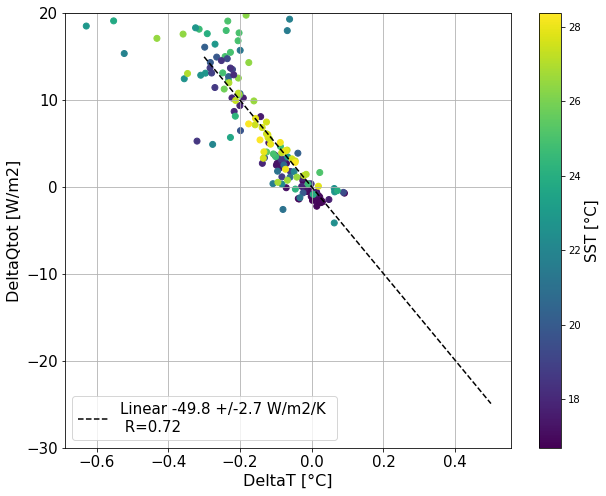

In [63]:
def linear(x,a):
    return a*x
DeltaQ=Qin-Qmean
Cond=(time_h[1:]>=365) & (time_h[1:]<=365*2) & ~np.isnan(DeltaQ) ## For QWA116
DeltaQa=DeltaQ[Cond] ; DeltaTa=DeltaT_h[Cond]

plt.figure(0, figsize=(10,8))
plt.scatter(DeltaTa,DeltaQa, c=SSTin_h[Cond])
R=np.cov(DeltaQa,DeltaTa)[0,1]**2/np.std(DeltaQa)**2/np.std(DeltaTa)**2
A0,S=opt.curve_fit(linear,DeltaTa,DeltaQa,[0])
plt.plot(np.arange(-0.3,0.6,0.1),linear(np.arange(-0.3,0.6,0.1),A0),'--k', label='Linear '+'%3.1f'%A0+' +/-'+'%2.1f'%S+' W/m2/K \n R='+'%0.2f'%R)

plt.grid() ; CB = plt.colorbar()
CB.set_label('SST [\N{DEGREE SIGN}C]', size=15)
plt.xlabel('DeltaT [\N{DEGREE SIGN}C]', size=16)
plt.ylabel('DeltaQtot [W/m2]', size=16)
plt.ylim([-30,20])
plt.tick_params(labelsize=15) ;plt.legend(fontsize=15)
#plt.title('Flux sensibility - '+str_title,size=18, y=1.02)

### Browsing all experiments.npy

In [64]:
Exps=np.array(['QWA113','QWA115','QWA116','QWA117','QWA118','QWA122','QWA120','QWA119-3','QWA119-4','QWA119-5','QWA213','QWA214'])
Names=['4K25-1H','2K50-1H','1K100-1H','1K100-1D','1K100-1W','1K100-3D','1K100-1H-NoSST','05K150-1H','05K150-1H','05K150-1H','1K40-1H','2K80-1H']

Vert=[25,50,100,100,100,100,100,150,150,150,40,80]*2
Ne=len(Exps)
Freq=['1-hour','1-hour','1-hour','1-day','1-week','3-days','1-hour' ,'1-hour','1-hour','1-hour','1-hour','1-hour']*2
Resol=['4','2','1','1','1','1','1','0.5','0.5','0.5','1','1']*2
Colors=['b','r','k','m','orangered','g','k','y','y','y','k','r']*2
Type2=(['-']*(Ne-2)+['--']*2)*2

t_bd=t_bd_bis+t_bd_ter


In [65]:
time_h=np.arange(0,2*365,2)

dT_m=np.zeros(Ne*2) ; dT_m10=np.zeros(Ne*2) ; MR_m=np.zeros(Ne*2) ; MR_30=np.zeros(Ne*2) ; MR_70=np.zeros(Ne*2)
dT_t=np.zeros((365,Ne)) ; MR_t=np.zeros((365,Ne)) ; MR_t50=np.zeros((365,Ne))
Mask=np.ones((365,Ne)) ; THFF=np.zeros(Ne) ; THFFerr=np.zeros(Ne) ; DMLD=np.zeros(Ne)

for e in tqdm(range(Ne)):
    DE=np.load(path_in+'DictEddy_HIS_'+Exps[e]+'.npy',allow_pickle=True) ; DE=DE.item()
    time_hbis=DE['time_h'] ; time_a=DE['time_a']
    zvert=DE['zvert'] ; id20 =np.argmin(np.abs(zvert+20)) ; id50 =np.argmin(np.abs(zvert+50))
    Qin=DE['Qin'] ; Qmean=DE['Qmean']
    SSTin_h=DE['SSTin_h'] ; SSTperif_h=DE['SSTperif_h']
    MixEddy_h=DE['MixEddy_h'] ; MixOut_h=DE['MixOut_h']
    MLDout_h=DE['MLDout_h'] ; 
    
    if e==1:
        MLDcore_h=DE['MLDrmax_h']
    else:
        MLDcore_h=DE['MLDcore_h']
    
    DeltaMLD_sm=nd.gaussian_filter1d(MLDcore_h-MLDout_h,sigma=2)
    DeltaT_h=SSTin_h-SSTperif_h ; DeltaQ=Qin-Qmean
    i0=int(time_hbis[0]/2)
    Nh=min(len(DeltaT_h),365-i0)
    
    Mask[i0:i0+Nh,e]=np.isnan(DeltaT_h)[:Nh]
    Mask=Mask.astype(bool)
    
    DeltaQ=Qin-Qmean                   #### Delta Q
    Cond=(time_a>=365) & (time_a<=365*2) & ~np.isnan(DeltaQ)
    DeltaQa=DeltaQ[Cond] ; DeltaTa=DeltaT_h[Cond]
    A0,S=opt.curve_fit(linear,DeltaTa,DeltaQa,[0])
    THFF[e]=A0 ; THFFerr[e]=S
    
    if e in [7,9]:#[7,9]:        ### Delta MLD
        DMLD[e]=np.nan
    elif e==8: # e==8:
        DMLD[e]=-np.nanmin(DeltaMLD_sm)
    else:
        DMLD[e]=-np.nanmin(DeltaMLD_sm[t_win[0]:t_win[1]])
    
    dT_t[i0:i0+Nh,e]=DeltaT_h[:Nh]     ## Temporal variables
    dT_t[:,e][Mask[:,e]]=np.nan
    MR_t[i0:i0+Nh,e]=np.average(MixEddy_h[:,id20:]/MixOut_h[:,id20:],axis=1)[:Nh]
    MR_t[:,e][Mask[:,e]]=np.nan
    MR_t50[i0:i0+Nh,e]=np.average(MixEddy_h[:,id50:]/MixOut_h[:,id50:],axis=1)[:Nh]
    MR_t50[:,e][Mask[:,e]]=np.nan
    
    for k in range(2):
        dT_m[e+k*Ne]=np.nanpercentile(dT_t[:,e][t_bd[0+2*k]:t_bd[1+2*k]],30)
        dT_m10[e+k*Ne]=np.nanpercentile(dT_t[:,e][t_bd[0]:t_bd[1+2*k]],10)

        MR_m[e+k*Ne]=np.nanmedian(MR_t[:,e][t_bd[0+2*k]:t_bd[1+2*k]])
        MR_30[e+k*Ne]=np.nanpercentile(MR_t[:,e][t_bd[0+2*k]:t_bd[1+2*k]],30)
        
xerr=MR_m-MR_30
yerr=dT_m-dT_m10

  0%|          | 0/12 [00:00<?, ?it/s]<ipython-input-65-817933854070>:44: RuntimeWarning: divide by zero encountered in true_divide
  MR_t[i0:i0+Nh,e]=np.average(MixEddy_h[:,id20:]/MixOut_h[:,id20:],axis=1)[:Nh]
<ipython-input-65-817933854070>:44: RuntimeWarning: invalid value encountered in true_divide
  MR_t[i0:i0+Nh,e]=np.average(MixEddy_h[:,id20:]/MixOut_h[:,id20:],axis=1)[:Nh]
<ipython-input-65-817933854070>:46: RuntimeWarning: divide by zero encountered in true_divide
  MR_t50[i0:i0+Nh,e]=np.average(MixEddy_h[:,id50:]/MixOut_h[:,id50:],axis=1)[:Nh]
<ipython-input-65-817933854070>:46: RuntimeWarning: invalid value encountered in true_divide
  MR_t50[i0:i0+Nh,e]=np.average(MixEddy_h[:,id50:]/MixOut_h[:,id50:],axis=1)[:Nh]
 17%|█▋        | 2/12 [00:00<00:00, 15.68it/s]/home6/datahome/abarboni/.conda/envs/croco/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/home6/datahome/abarboni/.conda/envs/cro

## Example for 1 experiment

Text(0.5, 1.0, 'Exp 1K100-1D / resol :1km / forcing :1-day')

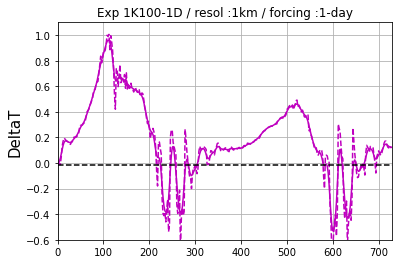

In [73]:
e=3  ## Choose one index here

time_h=np.arange(0,2*365,2)
Mask_e=np.ones(365) ; dT_e=np.zeros(365)
DE=np.load(path_in+'DictEddy_HIS_'+Exps[e]+'.npy',allow_pickle=True) ; DE=DE.item()
time_hbis=DE['time_h']; SSTin_h=DE['SSTin_h'] ; SSTperif_h=DE['SSTperif_h']
DeltaT_h=SSTin_h-SSTperif_h ; DeltaQ=Qin-Qmean
i0=int(time_hbis[0]/2) ; Nh=min(len(DeltaT_h),365-i0)

Mask_e[i0:i0+Nh]=np.isnan(DeltaT_h)[:Nh] ;Mask_e=Mask_e.astype(bool)

## Temporal variables
dT_e[i0:i0+Nh]=DeltaT_h[:Nh]
dT_e[:][Mask_e[:]]=np.nan
dT_em=np.nanpercentile(dT_e[t_bd[0]:t_bd[1]],50)

plt.plot(time_h, nd.gaussian_filter1d(dT_e,sigma=2),'-',color=Colors[e],label=Exps[e])
plt.plot(time_h, dT_e,'--',color=Colors[e],label=Exps[e])
plt.plot([0,365*2],[dT_em]*2,'--k')
plt.grid(); plt.xlim([0,365*2]) ; plt.ylim([-0.6,1.1])
plt.ylabel('DeltaT', size=15)
plt.title('Exp '+Names[e]+' / resol :'+Resol[e]+'km / forcing :'+Freq[e])

/home6/datahome/abarboni/.conda/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Delta T magnitude [°C]')

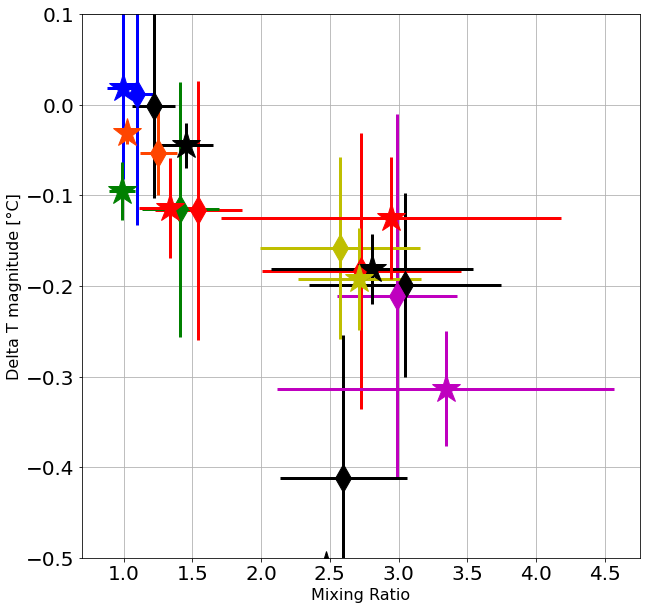

In [31]:
plt.figure(0, figsize=(10,10))
for e in range(Ne*2):
    if e>=Ne :
        fmt='*'; ms=30
    else:
        fmt='d'; ms=20
    E=plt.errorbar(MR_m[e],dT_m[e],xerr=xerr[e], yerr=yerr[e], fmt=fmt, ms=ms, color=Colors[e])#, label='SST retroaction')
    #plt.text(MR_m[e],dTy[e]+0.01,Resol[e]+'-'+Freq[e],size=15)
    E[-1][1].set_linestyle('-') ; E[-1][1].set_linewidth(3)
    E[-1][0].set_linestyle('-') ; E[-1][0].set_linewidth(3)

plt.tick_params(labelsize=20) ; plt.ylim([-0.5,0.1])
plt.xlabel('Mixing Ratio',size=16) ; plt.grid() #; plt.xlim([1,4]) ; plt.ylim([-0.2,0])
plt.ylabel('Delta T magnitude [\N{DEGREE SIGN}C]',size=16)

### Quick fix : merging individual files if one experiment is too heavy

In [32]:
dT_spec=np.ones(365)*20  ; MR_spec=np.ones(365)*20
for e in [7,8,9]:
    dT_spec[~np.isnan(dT_t[:,e])]=dT_t[~np.isnan(dT_t[:,e]),e]
    MR_spec[~np.isnan(dT_t[:,e])]=MR_t[~np.isnan(dT_t[:,e]),e]
dT_spec[dT_spec==20]=np.nan ; MR_spec[MR_spec==20]=np.nan

## Experiments with varying resolution

100%|██████████| 8/8 [00:00<00:00, 1376.93it/s]


Text(0.5, 0, 'Time [days]')

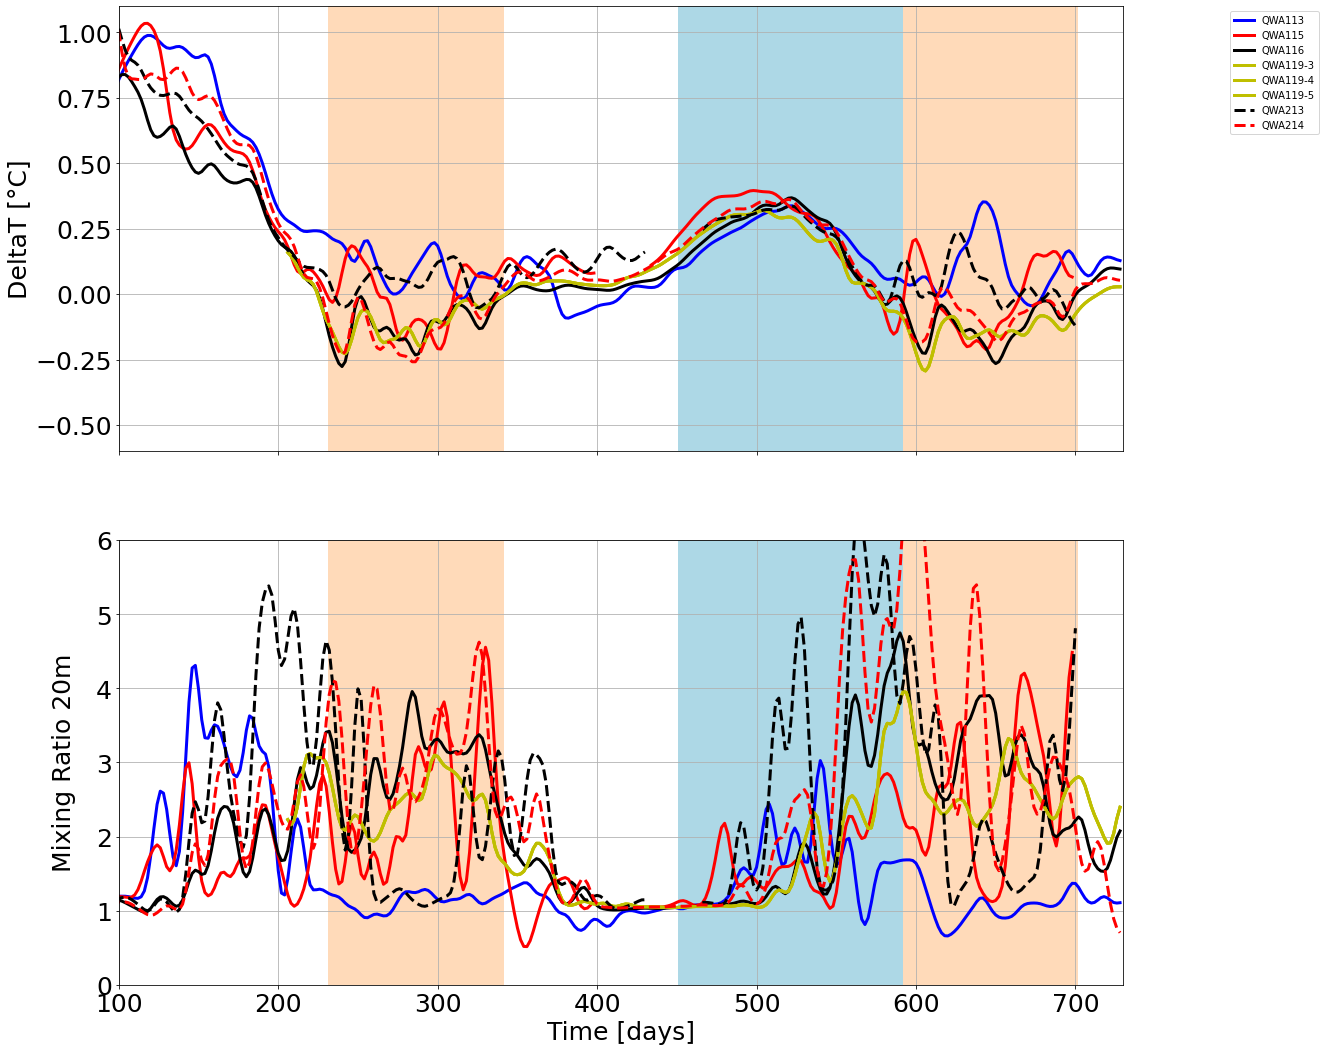

In [33]:
plt.figure(0, figsize=(18,18)) ; LS=25
VResol=np.array([0,1,2,7,8,9,10,11])#7,8,9])
#VResol=np.array([2,9,10])#7,8,9])

plt.subplot(211)
for e in tqdm(VResol):
    if e in [7,8,9]:
        plt.plot(time_h, nd.gaussian_filter1d(dT_spec,sigma=2),Type2[e],color=Colors[e],label=Exps[e],lw=3)
    else:
        plt.plot(time_h, nd.gaussian_filter1d(dT_t[:,e],sigma=2),Type2[e],color=Colors[e],label=Exps[e],lw=3)
plt.grid(); plt.xlim([100,365*2]) ; plt.ylim([-0.6,1.1]) ; plt.tick_params(labelbottom=False)
fill_seasons(t_bd_bis,t_bd_ter,t_win,[-400,300])
plt.ylabel('DeltaT [\N{DEGREE SIGN}C]', size=LS)
plt.legend(bbox_to_anchor=(1.2,1)) ; plt.tick_params(labelsize=LS)

plt.subplot(212)
for e in tqdm(VResol):
    if e in [7,8,9]:
        plt.plot(time_h, nd.gaussian_filter1d(MR_spec,sigma=2),Type2[e],color=Colors[e],lw=3)
    else:
        plt.plot(time_h, nd.gaussian_filter1d(MR_t[:,e],sigma=2),Type2[e],color=Colors[e],lw=3)
plt.ylabel('Mixing Ratio 20m', size=LS, labelpad=20) ;plt.ylim([0,6]) ; plt.xlim([100,365*2])
fill_seasons(t_bd_bis,t_bd_ter,t_win,[-400,300])
plt.tick_params(labelsize=LS)

plt.grid() #; plt.yscale('log') ; 
plt.xlabel('Time [days]', size=LS)

/home6/datahome/abarboni/.conda/envs/croco/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Delta T summer avg [°C]')

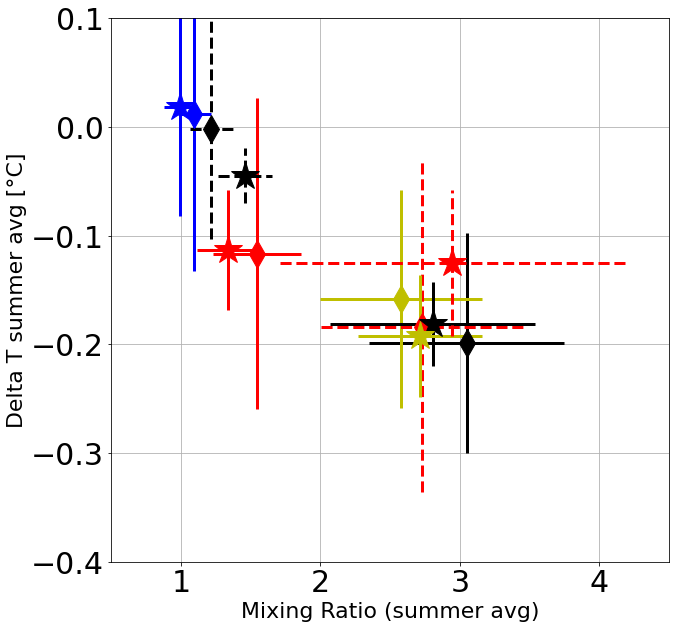

In [50]:
plt.figure(0, figsize=(10,10))
for e in list(VResol)+list(VResol+Ne):
    if e>=Ne :
        fmt='*'; ms=30
    else:
        fmt='d'; ms=20
    E=plt.errorbar(MR_m[e],dT_m[e],xerr=xerr[e], yerr=yerr[e], fmt=fmt, ms=ms, color=Colors[e])#, label='SST retroaction')
    E[-1][1].set_linestyle(Type2[e]) ; E[-1][1].set_linewidth(3)
    E[-1][0].set_linestyle(Type2[e]) ; E[-1][0].set_linewidth(3)

plt.tick_params(labelsize=30) ; plt.ylim([-0.4,0.1])
plt.xlabel('Mixing Ratio (summer avg)',size=22) ; 
plt.grid() ; plt.xlim([0.5,4.5]) #; plt.ylim([-0.2,0])
plt.ylabel('Delta T summer avg [\N{DEGREE SIGN}C]',size=22)

## Experiments with varying forcing frequency

100%|██████████| 4/4 [00:00<00:00, 1265.92it/s]


Text(0.5, 0, 'Time [days]')

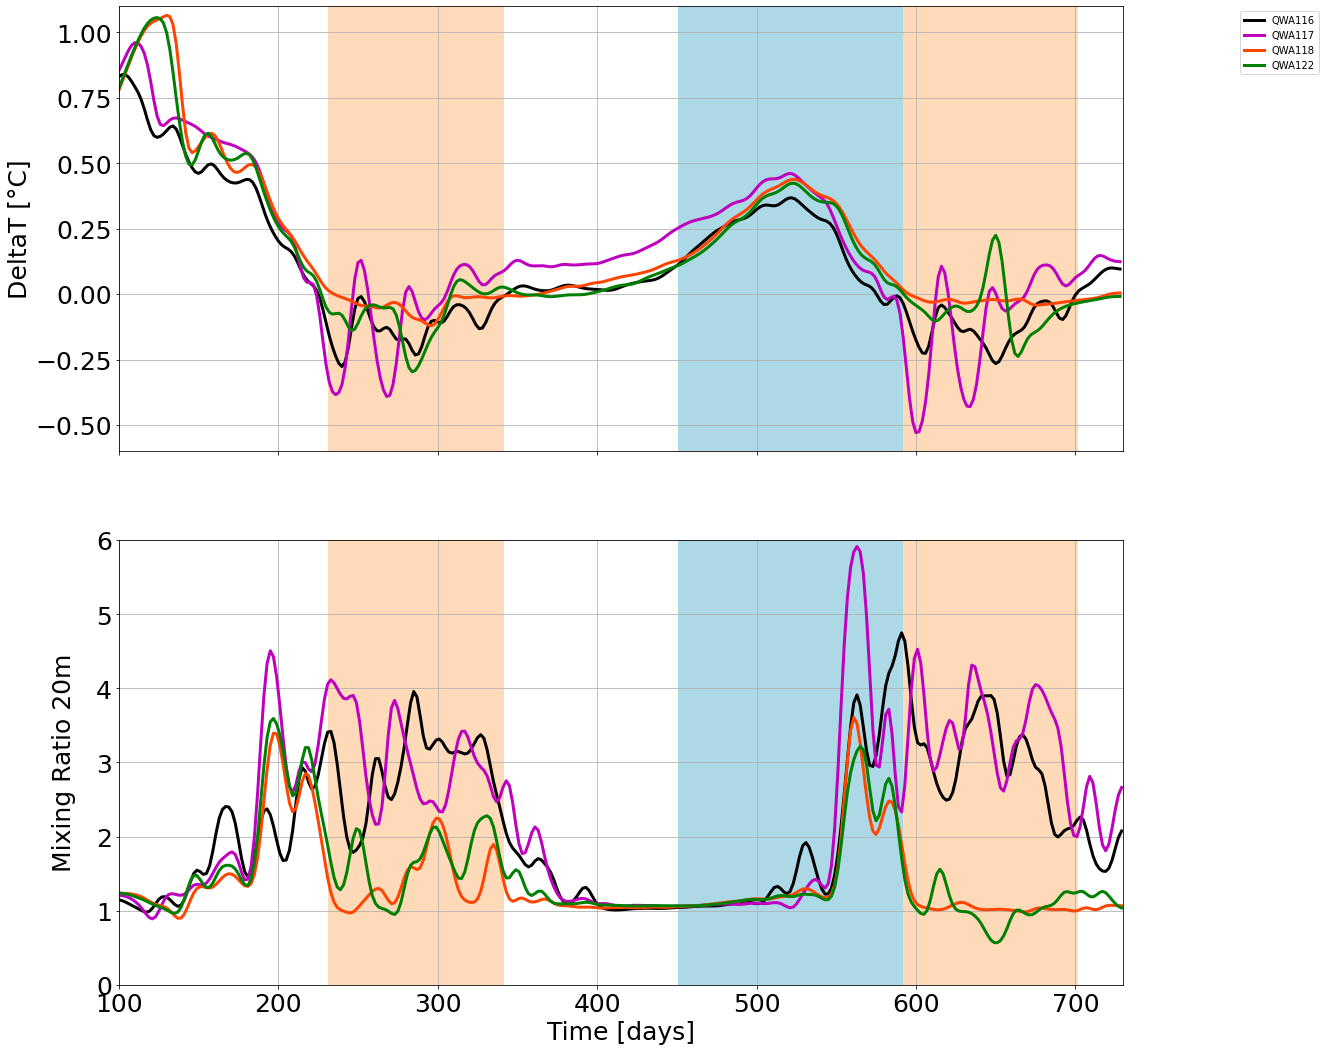

In [35]:
plt.figure(0, figsize=(18,18)) ; LS=25

VFreq=np.array([2,3,4,5])
plt.subplot(211)
for e in VFreq:
    plt.plot(time_h, nd.gaussian_filter1d(dT_t[:,e],sigma=2),Type2[e],color=Colors[e],label=Exps[e],lw=3)
plt.grid(); plt.xlim([100,365*2]) ; plt.ylim([-0.6,1.1]) ; plt.tick_params(labelbottom=False)
plt.ylabel('DeltaT [\N{DEGREE SIGN}C]', size=LS)
fill_seasons(t_bd_bis,t_bd_ter,t_win,[-400,300])
plt.legend(bbox_to_anchor=(1.2,1)) ; plt.tick_params(labelsize=LS)

plt.subplot(212)
for e in tqdm(VFreq):
    plt.plot(np.arange(1,365*2+1,2), nd.gaussian_filter1d(MR_t[:,e],sigma=2),Type2[e],color=Colors[e],lw=3)
plt.ylabel('Mixing Ratio 20m', size=LS, labelpad=20) ;plt.ylim([0,6]) ; plt.xlim([100,365*2])
fill_seasons(t_bd_bis,t_bd_ter,t_win,[-400,300])
plt.tick_params(labelsize=LS)

plt.grid() #; plt.yscale('log') ; 
plt.xlabel('Time [days]', size=LS)

Text(0, 0.5, 'Delta T summer avg [°C]')

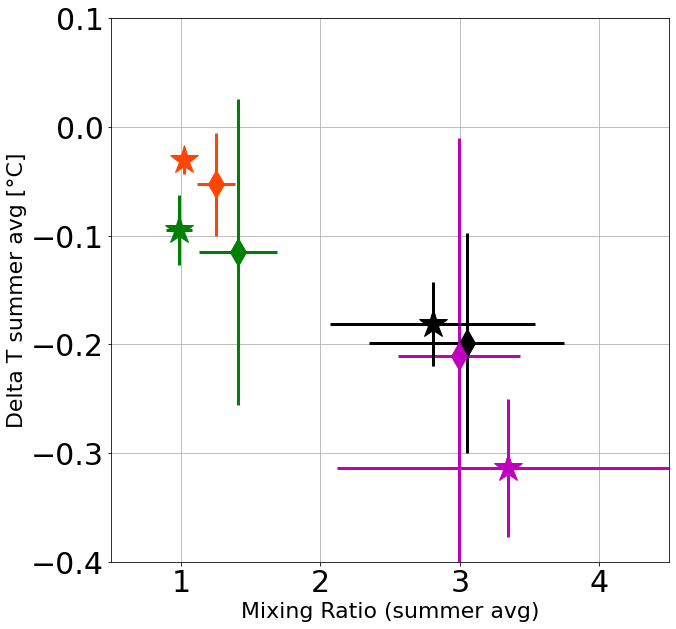

In [49]:
plt.figure(0, figsize=(10,10))
for e in list(VFreq)+list(VFreq+Ne):
    if e>Ne :
        fmt='*'; ms=30
    else:
        fmt='d'; ms=20
    E=plt.errorbar(MR_m[e],dT_m[e],xerr=xerr[e], yerr=yerr[e], fmt=fmt, ms=ms, color=Colors[e])#, label='SST retroaction')
    E[-1][1].set_linestyle(Type2[e]) ; E[-1][1].set_linewidth(3)
    E[-1][0].set_linestyle(Type2[e]) ; E[-1][0].set_linewidth(3)

plt.tick_params(labelsize=30) ; plt.ylim([-0.4,0.1])
plt.xlabel('Mixing Ratio (summer avg)',size=22) ; 
plt.grid() ; plt.xlim([0.5,4.5]) #; plt.ylim([-0.2,0])
plt.ylabel('Delta T summer avg [\N{DEGREE SIGN}C]',size=22)
